In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deepctr.models import DeepFM, AutoInt
from deepctr.feature_column import SparseFeat, VarLenSparseFeat, get_feature_names
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.python as tf
from sklearn.metrics import precision_score,recall_score,accuracy_score,roc_curve,auc

C:\Users\Omer\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.23) or chardet (5.0.0)/charset_normalizer (2.0.10) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


<h3> Data Preprocessing </h3>

In [2]:
users_df = pd.read_table("dataset/users.dat",sep="::",names=['id','gender','age','occupation','zip_code'])
movies_df = pd.read_table("dataset/movies.dat",sep="::",names=['id','title','genres'],encoding='latin-1')
ratings_df = pd.read_table("dataset/ratings.dat",sep="::",names=['user_id','movie_id','rating','timestamp'])

C:\Users\Omer\AppData\Local\Temp\ipykernel_3064\3793103997.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users_df = pd.read_table("dataset/users.dat",sep="::",names=['id','gender','age','occupation','zip_code'])
C:\Users\Omer\AppData\Local\Temp\ipykernel_3064\3793103997.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies_df = pd.read_table("dataset/movies.dat",sep="::",names=['id','title','genres'],encoding='latin-1')
C:\Users\Omer\AppData\Local\Temp\ipykernel_3064\3793103997.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (s

In [3]:
# join 3 different dataframe into 1 dataframe
df = pd.merge(ratings_df, movies_df, how='left', left_on='movie_id', right_on='id')
df = pd.merge(df, users_df, how='left', left_on='user_id', right_on='id')

In [4]:
df = df.drop(['id_x','timestamp','id_y'],axis=1)
df.head()

,user_id,movie_id,rating,title,genres,gender,age,occupation,zip_code
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


In [5]:
df.isnull().sum() # check if there are any null values

user_id       0
movie_id      0
rating        0
title         0
genres        0
gender        0
age           0
occupation    0
zip_code      0
dtype: int64

In [6]:
# extract the movie year information from the movie title
df['movie_year'] = df['title'].str[-5:-1].astype(int)

In [7]:
def group_movie_years(x):
    if x >= 1910 and x <= 1919:
        return "1910s"
    elif x >= 1920 and x <= 1929:
        return "1920s"
    elif x >= 1930 and x <= 1939:
        return "1930s"
    elif x >= 1940 and x <= 1949:
        return "1940s"
    elif x >= 1950 and x <= 1959:
        return "1950s"
    elif x >= 1960 and x <= 1969:
        return "1960s"
    elif x >= 1970 and x <= 1979:
        return "1970s"
    elif x >= 1980 and x <= 1989:
        return "1980s"
    elif x >= 1990 and x <= 1999:
        return "1990s"
    elif x >= 2000 and x <= 2009:
        return "2000s"

In [8]:
df['movie_year'] = df['movie_year'].apply(group_movie_years)

In [9]:
df['movie_year'].value_counts()

1990s    532843
1980s    224056
1970s     82552
1960s     48555
2000s     41000
1950s     35232
1940s     21501
1930s     12729
1920s      1696
1910s        45
Name: movie_year, dtype: int64

In [10]:
# classify if rating greater than 3 as like, otherwise dislike
df.loc[df.rating <= 3,'rating'] = 0
df.loc[df.rating > 3,'rating'] = 1

df = df.rename(columns ={'rating' : 'like'})
df.head()

,user_id,movie_id,like,title,genres,gender,age,occupation,zip_code,movie_year
0,1,1193,1,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067,1970s
1,1,661,0,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067,1990s
2,1,914,0,My Fair Lady (1964),Musical|Romance,F,1,10,48067,1960s
3,1,3408,1,Erin Brockovich (2000),Drama,F,1,10,48067,2000s
4,1,2355,1,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067,1990s


<h3> Deep FM Model Training </h3>

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [15]:
def split(x):
    key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            # Notice : input value 0 is a special "padding",so we do not use 0 to encode valid feature for sequence input
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

In [16]:
#data = pd.read_csv("demo-data.txt")
data = df

sparse_features = ["movie_id", "user_id","gender", "age", "occupation", "zip_code", "movie_year"]
target = ['like']

In [17]:
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])

In [123]:
fixlen_feature_columns = [SparseFeat(feat, data[feat].max() + 1, embedding_dim=16)
                          for feat in sparse_features]

In [124]:
key2index = {}
genres_list = list(map(split, data['genres'].values))
genres_length = np.array(list(map(len, genres_list)))
max_len = max(genres_length)
# Notice : padding=`post`
genres_list = pad_sequences(genres_list, maxlen=max_len, padding='post')

In [125]:
varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres', vocabulary_size=len(
            key2index) + 1, embedding_dim=16), maxlen=max_len, combiner='mean',
                                                   weight_name=None)]

In [126]:
linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

In [127]:
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [128]:
train, test = train_test_split(data, test_size=0.1, random_state=42, stratify=data.like.values)

train_model_input = {name: train[name].values for name in feature_names}
train_model_input['genres'] = genres_list[train.index]

test_model_input = {name: test[name].values for name in feature_names}
test_model_input['genres'] = genres_list[test.index]

In [129]:
optimizer = tf.keras.optimizer_v2.adam.Adam(learning_rate=0.001)

In [130]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [210]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary',
               l2_reg_dnn=0.0001,l2_reg_embedding=0.0001)
  
model.compile(optimizer, "binary_crossentropy", metrics=['accuracy'])

In [211]:
# ,callbacks=[sch]
history = model.fit(train_model_input, train[target].values,callbacks=[early_stopping],
                    batch_size=16384, epochs=30, verbose=2, validation_split=0.1)

Epoch 1/30
50/50 - 15s - loss: 0.6045 - accuracy: 0.6872 - val_loss: 0.5654 - val_accuracy: 0.7236
Epoch 2/30
50/50 - 11s - loss: 0.5568 - accuracy: 0.7276 - val_loss: 0.5540 - val_accuracy: 0.7259
Epoch 3/30
50/50 - 10s - loss: 0.5479 - accuracy: 0.7313 - val_loss: 0.5490 - val_accuracy: 0.7284
Epoch 4/30
50/50 - 11s - loss: 0.5420 - accuracy: 0.7340 - val_loss: 0.5464 - val_accuracy: 0.7307
Epoch 5/30
50/50 - 11s - loss: 0.5361 - accuracy: 0.7383 - val_loss: 0.5436 - val_accuracy: 0.7320
Epoch 6/30
50/50 - 11s - loss: 0.5303 - accuracy: 0.7431 - val_loss: 0.5404 - val_accuracy: 0.7365
Epoch 7/30
50/50 - 11s - loss: 0.5243 - accuracy: 0.7479 - val_loss: 0.5372 - val_accuracy: 0.7396
Epoch 8/30
50/50 - 11s - loss: 0.5184 - accuracy: 0.7519 - val_loss: 0.5346 - val_accuracy: 0.7423
Epoch 9/30
50/50 - 10s - loss: 0.5134 - accuracy: 0.7559 - val_loss: 0.5333 - val_accuracy: 0.7432
Epoch 10/30
50/50 - 10s - loss: 0.5083 - accuracy: 0.7592 - val_loss: 0.5312 - val_accuracy: 0.7450
Epoch 11/

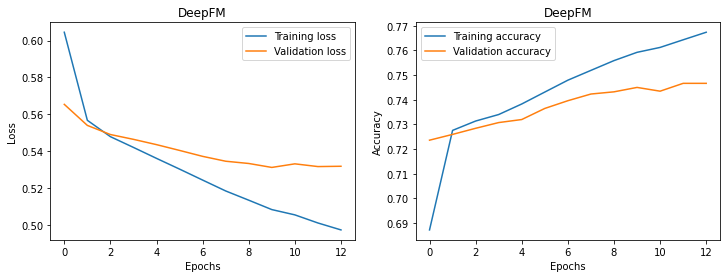

In [212]:
# plot training and validation metrics
epochs = len(history.history['loss'])
_, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(range(epochs),history.history['loss'],label='Training loss')
ax[0].plot(range(epochs),history.history['val_loss'],label='Validation loss')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("DeepFM")
ax[0].legend()

ax[1].plot(range(epochs),history.history['accuracy'],label='Training accuracy')
ax[1].plot(range(epochs),history.history['val_accuracy'],label='Validation accuracy')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("DeepFM")
ax[1].legend()

In [213]:
test_preds = model.predict(test_model_input)

In [215]:
precision = precision_score(test[target].values,np.where(test_preds >= 0.5,1,0))
recall = recall_score(test[target].values,np.where(test_preds >= 0.5,1,0))
accuracy = accuracy_score(test[target].values,np.where(test_preds >= 0.5,1,0))

print(f"Precision: {precision}\nRecall: {recall}\nAccuracy: {accuracy}")

Precision: 0.7599671121572168
Recall: 0.8194270616047837
Accuracy: 0.7472830705551834


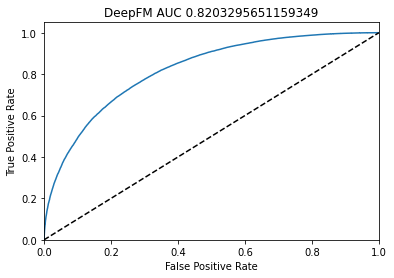

In [216]:
# calculate the auc score
fpr,tpr,_ = roc_curve(test[target].values,test_preds)
score = auc(fpr,tpr)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"DeepFM AUC {score}")
plt.show()

In [217]:
model.save_weights('deepfm.h5')